This doesn't work at all !
And it's not too surprising... A manual registration approach could be more interesting.

In [57]:
import sys
import pathlib

sys.path.insert(0, str(pathlib.Path("..").resolve()))
import msi_zarr_analysis

In [58]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from rasterio.features import rasterize
from shapely.affinity import affine_transform
from shapely.geometry import Polygon

from msi_zarr_analysis.utils.autocrop import autocrop

In [59]:
def compute_simple_registration(moving: np.ndarray, fixed: np.ndarray):
    
    def _preprocess(image: np.ndarray):
        _, image = cv2.threshold(image, 50, 255, cv2.THRESH_BINARY)
        return cv2.medianBlur(image, 3)

    moving = _preprocess(moving)
    fixed = _preprocess(fixed)

    m_crop_y, m_crop_x = autocrop(moving)
    m_crop = moving[m_crop_y, m_crop_x]

    f_crop_y, f_crop_x = autocrop(fixed)
    f_crop = fixed[f_crop_y, f_crop_x]

    fy = f_crop.shape[0] / m_crop.shape[0]
    fx = f_crop.shape[1] / m_crop.shape[1]

    m_scaled = cv2.resize(m_crop, dsize=None, fy=fy, fx=fx, interpolation=None)

    # x -> ratio * (x - mc_x) + fc_x
    # y -> ratio * (y - mc_y) + fc_y

    return [
        fx, 0,  # a, b
        0, fy,  # d, e
        f_crop_x.start - fx * m_crop_x.start,  # xoff
        f_crop_y.start - fy * m_crop_y.start,  # yoff
    ], m_scaled, f_crop

# img1 = cv2.imread("../02132071-6b87-47aa-834b-d31d493a6a09-image.png", cv2.IMREAD_GRAYSCALE)
# img2 = cv2.imread("../02132071-6b87-47aa-834b-d31d493a6a09-template.png", cv2.IMREAD_GRAYSCALE)

#img1 = cv2.imread("../1682421996190065283-image.png", cv2.IMREAD_GRAYSCALE)
#img2 = cv2.imread("../1682421996190065283-template.png", cv2.IMREAD_GRAYSCALE)

img1 = cv2.imread("../1682422007516166056-image.png", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread("../1682422007516166056-template.png", cv2.IMREAD_GRAYSCALE)

affine_matrix, roi1, roi2 = compute_simple_registration(img1, img2)

print(f"{affine_matrix=!r}")

affine_matrix=[0.13333333333333333, 0, 0, 0.11956521739130435, -31.799999999999997, -36.94565217391305]


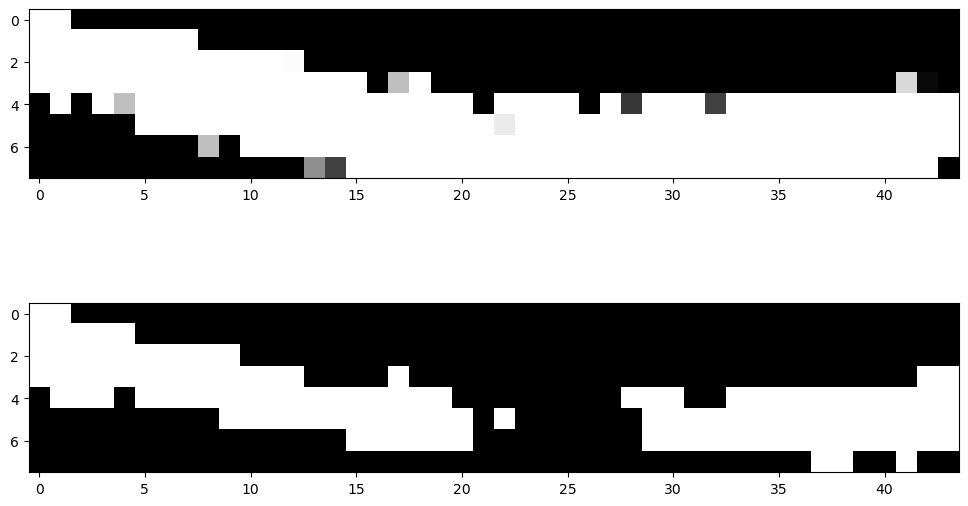

In [60]:
fig, ax = plt.subplots(2, 1, figsize=(12, 7))
ax[0].imshow(np.rot90(roi1), cmap="gray")
ax[1].imshow(np.rot90(roi2), cmap="gray")

In [61]:
roi1.shape, roi1.dtype, roi1.max(), roi1.min()

((44, 8), dtype('uint8'), 255, 0)

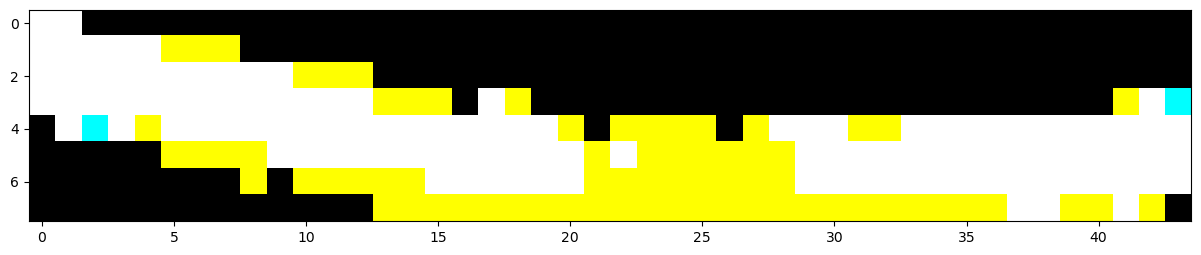

In [62]:
# make a pretty diff
# roi1 is (255, 255, 0) ; roi2 is (0, 255, 255)
# compute logical OR to have
#   - common in white
#   - roi1 only in yellow
#   - roi2 only in cyan
#   - negative in black

mask1 = np.stack(3*[roi1], axis=-1)
mask1[..., 2] = 0

mask2 = np.stack(3*[roi2], axis=-1)
mask2[..., 0] = 0

mask = 255 * np.uint8(np.logical_or(mask1, mask2))

fig, ax = plt.subplots(figsize=(15, 4))
ax.imshow(np.rot90(mask))

In [63]:
pol_1 = Polygon([[250, 250], [250, 1500], [350, 1500], [350, 250]])
pol_2: Polygon = affine_transform(pol_1, affine_matrix)

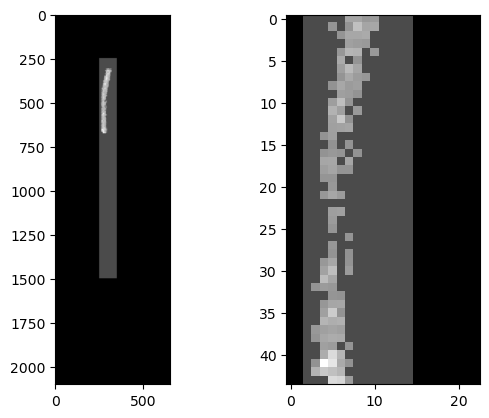

In [64]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img1, cmap="gray")
ax[0].imshow(rasterize([pol_1], img1.shape), cmap="gray", alpha=.3)
ax[1].imshow(img2, cmap="gray")
ax[1].imshow(rasterize([pol_2], img2.shape), cmap="gray", alpha=.3)

In [65]:
matrix_33 = np.array([
    [affine_matrix[0], affine_matrix[1], affine_matrix[4]],
    [affine_matrix[2], affine_matrix[3], affine_matrix[5]],
    [0, 0, 1],
])
matrix_inv_33 = np.linalg.inv(matrix_33)
matrix_inv = [matrix_inv_33[0, 0], matrix_inv_33[0, 1], matrix_inv_33[1, 0], matrix_inv_33[1, 1], matrix_inv_33[0, 2], matrix_inv_33[1, 2]]

pol_2 = Polygon([[5, 10], [5, 200], [18, 200], [18, 10]])

pol_1 = affine_transform(pol_2, matrix_inv)

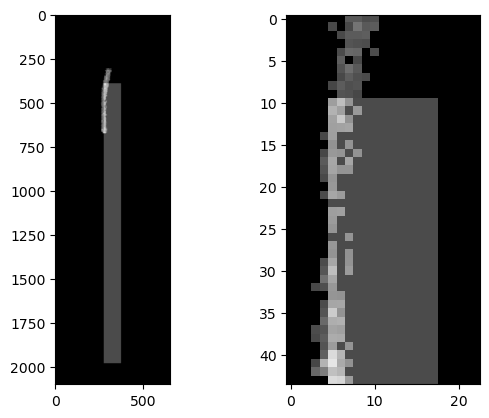

In [66]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img1, cmap="gray")
ax[0].imshow(rasterize([pol_1], img1.shape), cmap="gray", alpha=.3)
ax[1].imshow(img2, cmap="gray")
ax[1].imshow(rasterize([pol_2], img2.shape), cmap="gray", alpha=.3)